In [1]:
import os
import multiprocessing as mp
import glob
import matplotlib.pyplot as plt
from itertools import repeat
from tqdm import tqdm_notebook as tqdm
from utils import *
import timeit

## Basic Parameters

In [2]:
### coefficients for generating RBC
c0 = 0.2072
c1 = 2.0026
c2 = -1.1228

### refractive index of RBC and medium
n_rbc = 1.395
n_med = 1.334

### the radius of RBC in um
R = 3.9               #(um)

### wavelength of light source
wavelength = 0.532    #(um)

### the pixelsize of CMOS and magnification on optics setup
dx = 5.5             #(um)
mag = 85

### calcuate the grid number of RBC
grids = round((R*2) / (dx/mag))    # Ngrid= (2 x radius) / actural size per pixel

cmap = plt.cm.gray

### plugin number
plug_no = 2    #1: opticspy; 2: prysm

## import data and check the crop image

/media/share/HDD2TB/cTDM/RI/healthy/sun/0909_sun_532/


/media/share/HDD2TB/cTDM/RI/healthy/sun/0909_sun_532/1.raw
1.3368


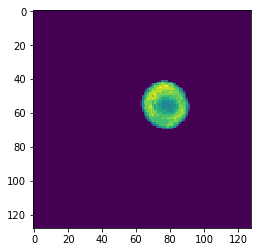

In [3]:
ri_folder = []
ri_folder.append('/media/share/HDD2TB/cTDM/RI/healthy/sun/0909_sun_532/')

for idx, folder in enumerate(ri_folder):
    print(folder)
    
    for file_RI in tqdm(glob.glob(folder + '1.raw')[:1]):
        print(file_RI)
        rimap, cent = cropRI(importRI(file_RI))

In [4]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.transform import resize
def f(x):    
#     plt.figure(figsize=(10,10))
    plt.imshow(rimap[:,:,x], cmap=plt.cm.jet)
    plt.show()
#     print('File: %s \nAP/LAT: %s \nDisease: %s \nFrames: %s '%(df['file'][x],df['view'][x],df['type'][x],df['frames'][x]))

interact(f, x=widgets.IntSlider(min=0,max=np.shape(rimap)[2]-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='x', max=127), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

## Calculating the angles of rotation and orientation

In [5]:
plug_no = 2
thetaN = 36
phiN = 36
rotation = np.linspace(0,360, num=thetaN, endpoint=False).astype(np.int)
orientation = np.linspace(-180,180, num=phiN, endpoint=False).astype(np.int)
# rotation = 0
args = []

for theta in np.nditer(rotation):
    for phi in np.nditer(orientation):
        args.append((rimap, wavelength, float(theta),float(phi), plug_no))
        
start = timeit.default_timer()

pool = mp.Pool(8)
# zc_list = [pool.starmap(zernikeFitting, zip(repeat(rimap), repeat(wavelength), (rotation), (orientation), repeat(2)))] 
zc_list = [pool.starmap(zernikeFitting, args)] 
pool.close()
pool.join()

stop = timeit.default_timer()
print('Time: %.3f sec' %(stop - start) )

zc = np.array(zc_list)

if plug_no is 1:
    c1 = zc[:,:,1]
    c2 = zc[:,:,2]
    c4 = zc[:,:,3]
elif plug_no is 2:
    c1 = zc[:,:,2]
    c2 = zc[:,:,1]
    c4 = zc[:,:,3]

Time: 81.550 sec


In [11]:
np.save('ZC-healthy',zc)

## Estimate the normalized C4 and generate the distribution

RMSE: 0.501


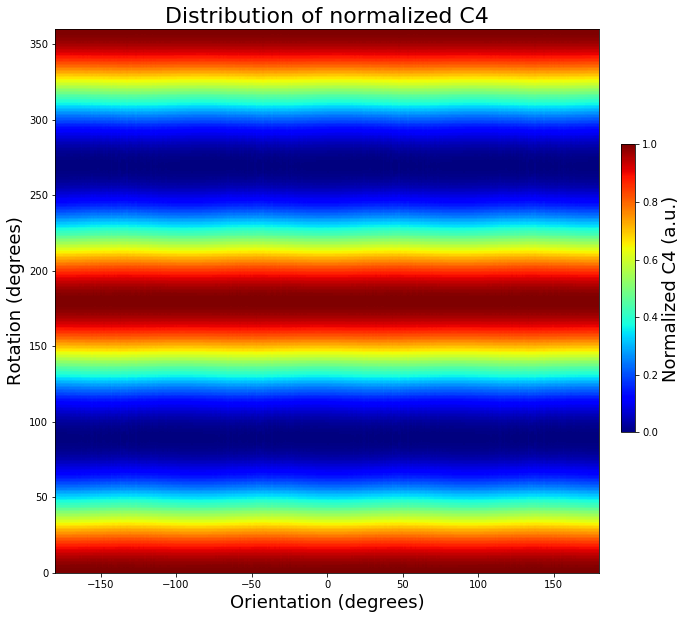

In [8]:
nc4 = (c4.copy()).reshape((thetaN,phiN))

for phi in range (len(orientation)):
    nc4[:,phi] = normalize(nc4[:,phi])
    
standard_theta = np.zeros((thetaN, phiN))
for theta in range (len(rotation)):
    standard_theta[theta,:] = np.power(np.cos(theta*10*np.pi/180),2)
    
    
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(standard_theta, nc4))
print('RMSE: %.3f' %(rmse))
    
fig, ax = plt.subplots(figsize=(10, 10), ncols=1)
im=ax.imshow(nc4, cmap=plt.cm.jet, extent=(-180, 180, 0, 360))
ax.set_title('Distribution of normalized C4', fontsize=22)
ax.set_xlabel('Orientation (degrees)', fontsize=18)
ax.set_ylabel('Rotation (degrees)', fontsize=18)
cbar_ax = fig.add_axes([0.92, 0.32, 0.020, 0.4])    #L, B, W, H
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical').set_label(label='Normalized C4 (a.u.)', size=18)
cbar_ax.yaxis.set_ticks_position('right')

plt.show()  

## Convert the normalized c4 to rotation

RMSE: 2.476


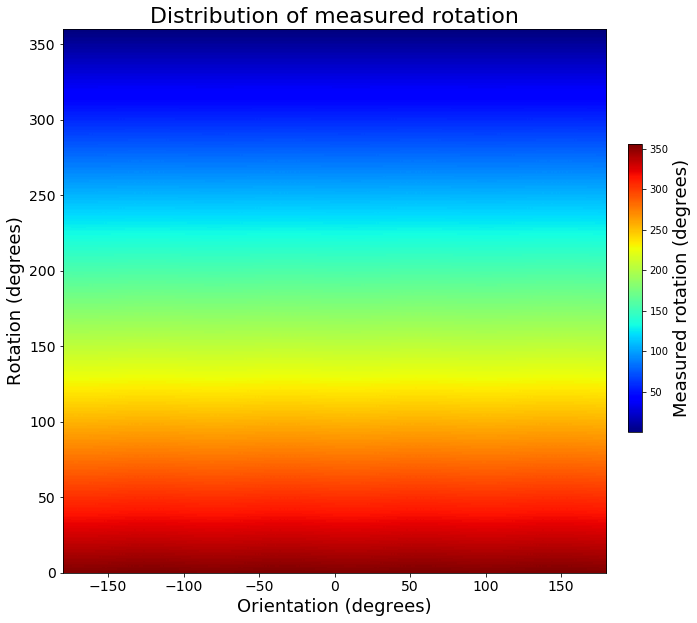

In [9]:
dist = (c4.copy()).reshape((thetaN,phiN))

for phi in range (len(orientation)):
    dist[:,phi] = normalize(dist[:,phi])
    dist[:,phi] = c4_to_rotation(dist[:,phi])
#     dist[:,phi] = np.arccos(np.sqrt(normalize(dist[:,phi])))*180/np.pi
    
standard_theta = np.zeros((thetaN, phiN))
for theta in range (len(rotation)):
#     standard_theta[theta,:] = np.power(np.cos(theta*10*np.pi/180),2)
    standard_theta[theta,:] = rotation[theta]
    
    
# rmse = np.linalg.norm(standard_theta - dist) / np.sqrt(thetaN*phiN)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(standard_theta, dist))
print('RMSE: %.3f' %(rmse))
    
fig, ax = plt.subplots(figsize=(10, 10), ncols=1)
im=ax.imshow(dist, cmap=plt.cm.jet, extent=(-180, 180, 0, 360))
ax.set_title('Distribution of measured rotation', fontsize=22)
ax.set_xlabel('Orientation (degrees)', fontsize=18)
ax.set_ylabel('Rotation (degrees)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
cbar_ax = fig.add_axes([0.92, 0.32, 0.020, 0.4])    #L, B, W, H
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical').set_label(label='Measured rotation (degrees)', size=18)
cbar_ax.yaxis.set_ticks_position('right')

plt.show()  
fig.savefig("rotation.png", bbox_inches="tight", pad_inches=0, dpi=300)

## Estimate the orientation and generate the distribution

RMSE: 1.299
0.7965982739734718


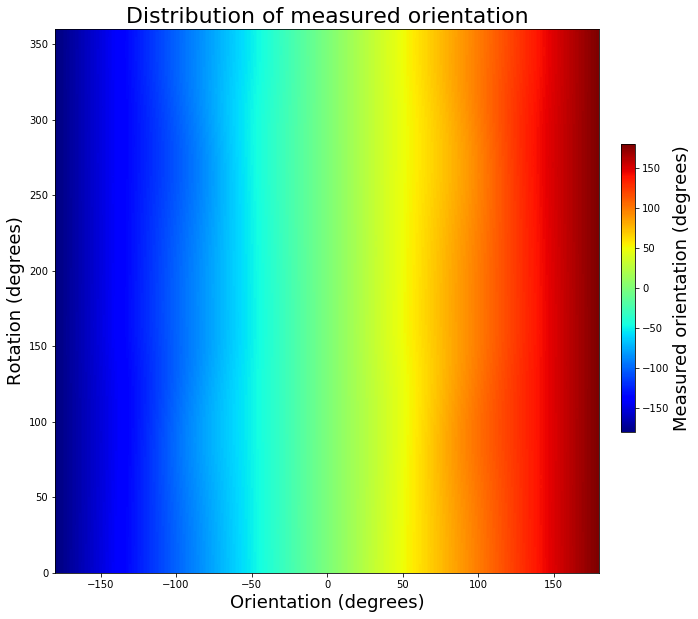

In [18]:
tan = (np.arctan2(c1,c2)*180/np.pi).reshape((thetaN,phiN))

for theta in range (len(rotation)):
    tan[theta,:] -= tan[theta,0]
    tan[theta,:]  = tan[theta,:] %360 - 180

standard_phi = np.zeros((thetaN, phiN))
for phi in range (len(orientation)):
    standard_phi[:,phi] = phi-180
    
rmse = sqrt(mean_squared_error(standard_phi, tan))
print('RMSE: %.3f' %(rmse))

mae = np.sum(np.absolute(standard_phi - tan)) / (thetaN*phiN)
print(mae)

fig, ax = plt.subplots(figsize=(10, 10), ncols=1)
im=ax.imshow(tan, cmap=plt.cm.jet, extent=(-180, 180, 0, 360))
ax.set_title('Distribution of measured orientation', fontsize=22)
ax.set_xlabel('Orientation (degrees)', fontsize=18)
ax.set_ylabel('Rotation (degrees)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=10)
cbar_ax = fig.add_axes([0.92, 0.32, 0.020, 0.4])    #L, B, W, H
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical').set_label(label='Measured orientation (degrees)', size=18)
cbar_ax.yaxis.set_ticks_position('right')

plt.show()  

fig.savefig("orientation.png", bbox_inches="tight", pad_inches=0, dpi=300)

In [ ]:
nrows=6
ncols=6

rotation = np.linspace(0,360, num=nrows, endpoint=False).astype(np.int)
orientation = np.linspace(-180,180, num=ncols, endpoint=False).astype(np.int)

plug_no = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12),sharex=True, sharey=True)

zc_list = []

start = timeit.default_timer()
# outputDir = './Simualted_RBC'
for theta in tqdm(np.nditer(rotation)):
    for phi in np.nditer(orientation):
        new_S = rotate(rimap, theta, axes=(1,2), reshape=False)
        new_S = rotate(new_S, phi, axes=(0,1), reshape=False)

        proj = np.sum(new_S, axis = 2)*(1/(2*np.pi/wavelength))
#         phasemap = proj*2*np.pi/wavelength*(n_rbc-n_med)
        c = theta//10%ncols
        r = (theta//10-c)//ncols
        ax = axes[r,c]
        ax.imshow(proj, cmap)

#         if plug_no is 1:
#             ZC,C = opticspy.zernike.fitting(proj, 37, display=False)
#         else:
#             zernike.change_backend('cu')
#             ZC = zernikefit(proj, norm=False, terms=37, map_='noll')
    #     tmpPM[sr:er,sc:ec]=phasemap
#         zc_list.append(ZC)
        
stop = timeit.default_timer()
print('Time: %.3f sec' %(stop - start) )

    #     phasemap_list.append(tmpPM)

    #     if not os.path.exists(outputDir):
    #         os.makedirs(outputDir)
    #     SavePath = '%s/buffer%03d.phimap' %(outputDir,int(theta/10)+1)
    #     exportPM(SavePath, True, theta*np.pi/180, 0.0, nr, nc, tmpPM)

plt.show()
zc = np.array(zc_list)

In [ ]:
c4 = zc[:,4]
norm_c4 = normalize(c4)
print(norm_c4)

cosline = np.power(np.cos(np.arange(0,360)*np.pi/180),2)

fig, ax = plt.subplots()

ax.scatter(rotation, norm_c4, c='r', marker='x')
ax.plot(np.arange(0,360), cosline, 'b-')
ax.set(xlabel='Rotation (degree)', ylabel='Normalized C4 (a.u.)',
       title='c4 vs. $cos^{2}$(θ)')
plt.show()

In [ ]:
tt = np.arctan2(c1,c2)*180/np.pi
tt -= tt[0,0]
tt = tt%360 - 180

fig, ax = plt.subplots()

ax.scatter((orientation), tt, c='r', marker='x')
ax.plot((orientation), (orientation), 'b-')
ax.set(xlabel='Orientation (degree)', ylabel='Measurement angle (degree)',
       title='$tan^{-1}$(c1/c2) vs. orientation')
plt.show()